<h1 style="color:red";> Our research question</h1>

<p>How many citations (according to <a href="http://opencitations.net/download#coci"><b>COCI</b></a>) involve, either as citing or cited entities, publications in SSH journals (according to <a href="https://kanalregister.hkdir.no/publiseringskanaler/erihplus/periodical/listApproved"><b>ERIH-PLUS</b></a>) included in <b>OpenCitations Meta</b>? What are the disciplines that cites the most and those cited the most? How many citations start from and go to publications in OpenCitations Meta that are not included in SSH journals?</p>


<h2 style="color:red;">27/03</h2>

<p>Today I started thinking about the abstract and first of all I have read <a href="https://www.emeraldgrouppublishing.com/how-to/authoring-editing-reviewing/write-article-abstract#structured-abstract">the guideline</a> proposed by Emerald Publishing to sketch it.</p>
<p><b>Maximum amout of words</b>: "most journal author guidelines set a maximum of 250 words, including keywords and article classification".</p>

<p>In order to try to figure out the methodology to follow to answer to our rearch question, I thought it could have been useful to start exploring the <b>structure of the data</b>. I've downloaded the list of approved journals in ERIH-PLUS in the csv format and also one archive of COCI's dump.</p>

<h4>ERIH PLUS data</h4>

In [1]:
import pandas as pd
df_ErihPlus = pd.read_csv("2023-03-27 ERIH PLUS approved journals and series.csv", sep=";")

In [2]:
df_ErihPlus.columns

Index(['Journal ID', 'Print ISSN', 'Online ISSN', 'Original Title',
       'International Title', 'Country of Publication',
       'ERIH PLUS Disciplines', 'OECD Classifications', '[Last Updated]'],
      dtype='object')

In [3]:
df_ErihPlus.dtypes

Journal ID                 int64
Print ISSN                object
Online ISSN               object
Original Title            object
International Title       object
Country of Publication    object
ERIH PLUS Disciplines     object
OECD Classifications      object
[Last Updated]            object
dtype: object

<h4>COCI data</h4>

In [4]:
import zipfile
from os.path import exists, makedirs

def extract_file(input_dir, output_dir):
    if not output_dir:
            if not exists(output_dir):
                makedirs(output_dir)
    with zipfile.ZipFile(input_dir, 'r') as zip_ref:
        zip_ref.extractall(output_dir)    

In [5]:
extract_file("2022-12-31T201913_0-19_1.zip", "COCI_data")

<p>In each csv there are 7 columns: oci, citing (doi), cited (doi), creation (date), timespan, journal_sc (yes or no), author_sc(yes or no). The two columns provide the information to know if the citing and cited entities share at least one author and if they have been published in the same journal.</p>
<p>OCI is the OpenCitation identifier for the citation.</p>

<h2 style="color:red;">28/03</h2>

<h4>Abstract</h4>

<p>Today we met to write the abstract. The following is the first version of it:</p>
<p>Purpose: we want to find out
    <ol>
    <li>by looking at citations data contained in COCI, the number of citations included in Meta which refer to publication in SSH (Social Sciences and Humanities) journals indicated in ERIH-PLUS</li>
    <li>the disciplines citing the most VS the disciplines cited the most</li>
    <li>the citations from/to publication contained in Meta which are not included in SSH journals</li> 
    </ol>
We want to create a connection between these three different datasets for having an overall view of the citations present in each of them.</p>
<p>
Methodology: we approach the problem from a computational point of view, by building a python software able to analyse the data, querying them in order to retrieve the info needed and to present the results in a clear and understandable way.</p>
<p>
Findings: for what concerns the findings, we can see that there are no meaningful differences in the number of citations coming from different disciplines, since it is related to the subject of the study, while the ones cited the most belong to psychology, health and science studies.</p>
<p>
Originality/Value: the research conducted by us can be defined as very valuable, since it adds information to existing resources with the aim of facilitating their use and allowing the users to have a clearer view of the data contained in each dataset. Further development can be made, for example analysing other disciplines, to have the same overview as the one created by us but related to other fields.</p>

<p>Keywords: OpenScience, Citation, OC-COCI, OC-Meta, ERIH-PLUS, journals</p>

<h4>Data analysis</h4>

<p>I went on analysing the data we'll have to handle for the project, in particular, after having downloaded the META dump, I tried to figure the csv columns to use to create a connection between the three different datasets in order to answer to the research question.</p>

<img src="tables.png">

<p>COCI is the index of Crossref open DOI-to-DOI citations, and from the OpenCitation website we can read that COCI does not index Crossref references that are not open, nor Crossref open references to entities that lack DOIs. </p>

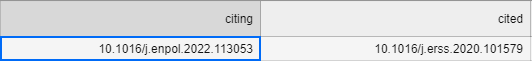

<p>Every entity in OpenCitations Meta is assigned persistent internal identifier called OpenCitations Meta Identifier (OMID).</p>

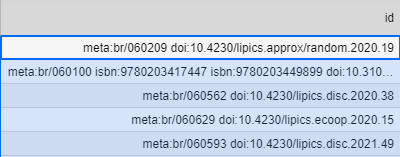

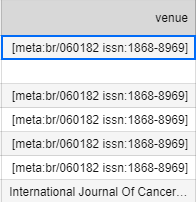

In [4]:
import pandas as pd
Meta_csv = pd.read_csv("0.csv", sep=",")

In [6]:
Meta_csv.dtypes

id            object
title         object
author        object
issue         object
volume       float64
venue         object
page          object
pub_date      object
type          object
publisher     object
editor        object
dtype: object

<p>So in order to connect Meta and the ERIH PLUS csv we have to take into account the ISSN</p>

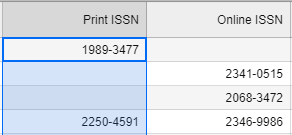